In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from utils.config import * 
from models_config.model_config_GSP import *


## Reproducibility

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_78604/1174398818.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


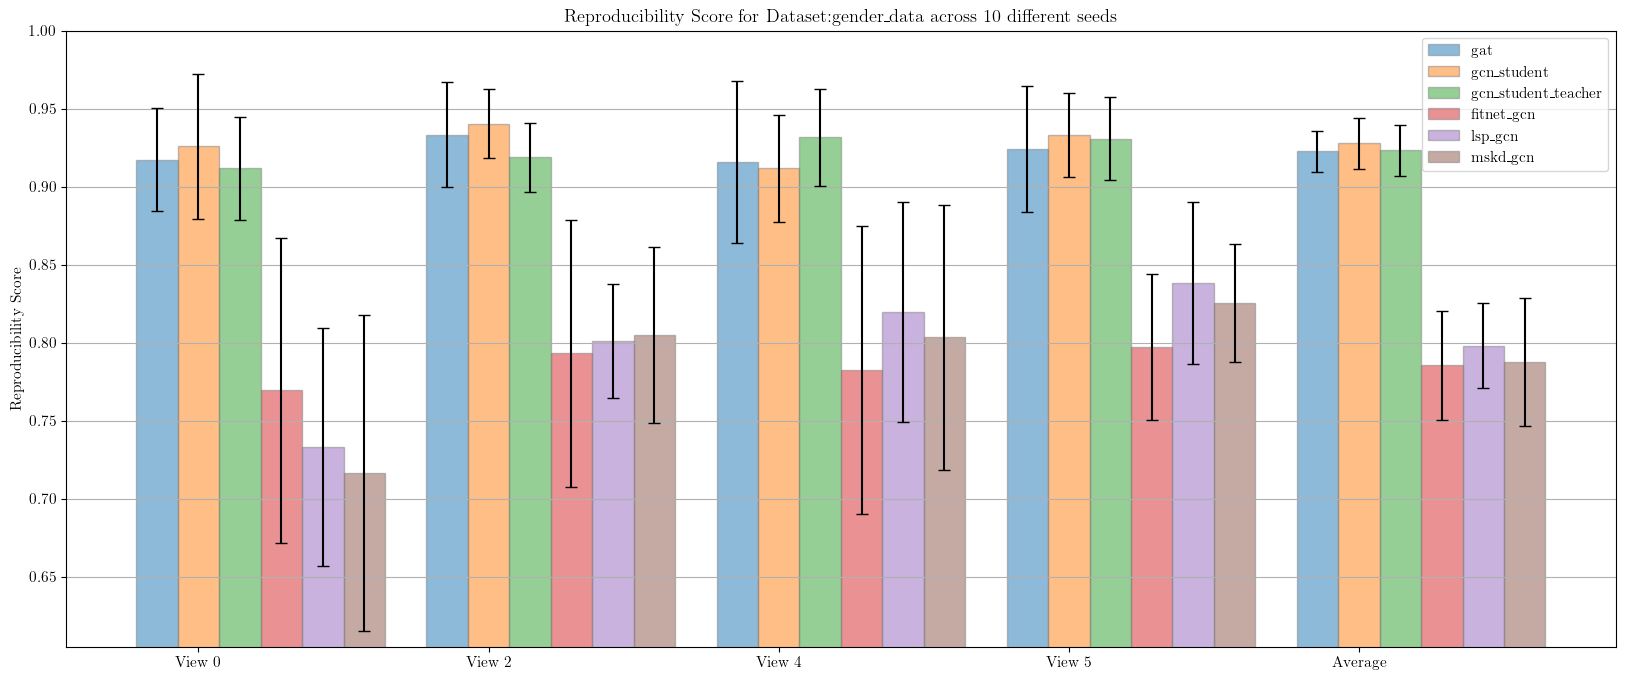

<Figure size 2000x800 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="gender_data"
views=[0, 2, 4, 5]
models=["gat", "gcn_student", "gcn_student_teacher", "fitnet_gcn", "lsp_gcn", "mskd_gcn"]
model_args = [gat_args, gcn_student_args, gat_student_args, gat_fitnet_student_args, gat_lsp_student_args, gat_mskd_student_args]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

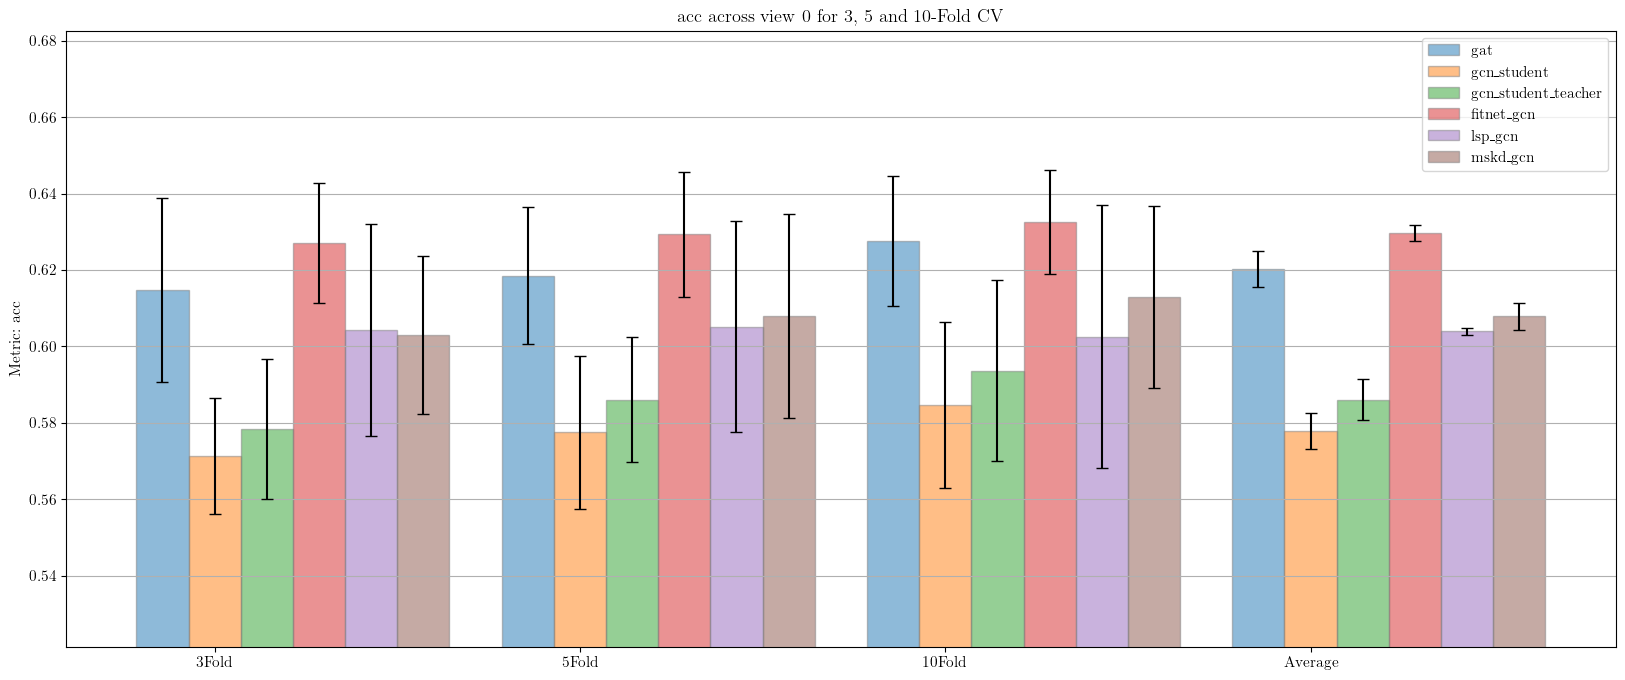

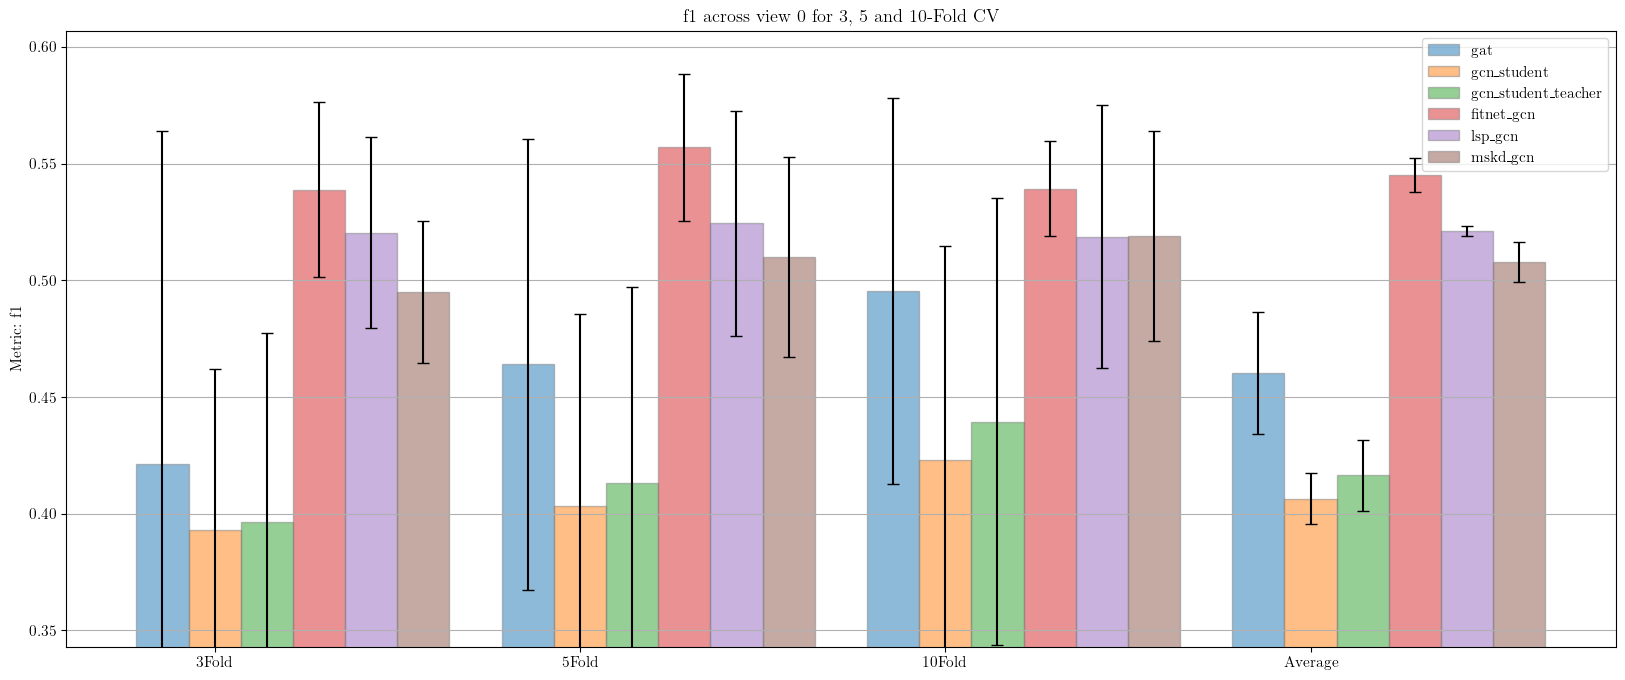

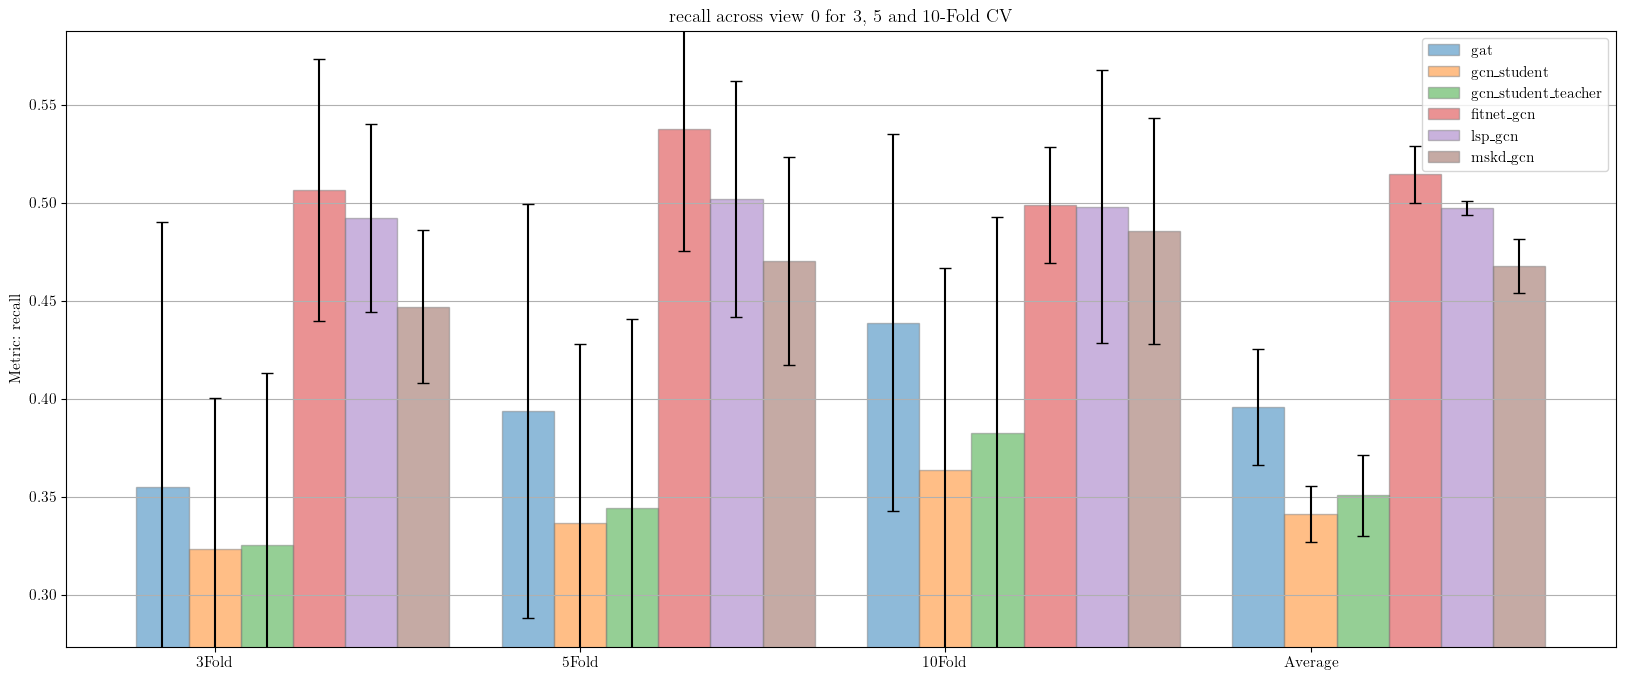

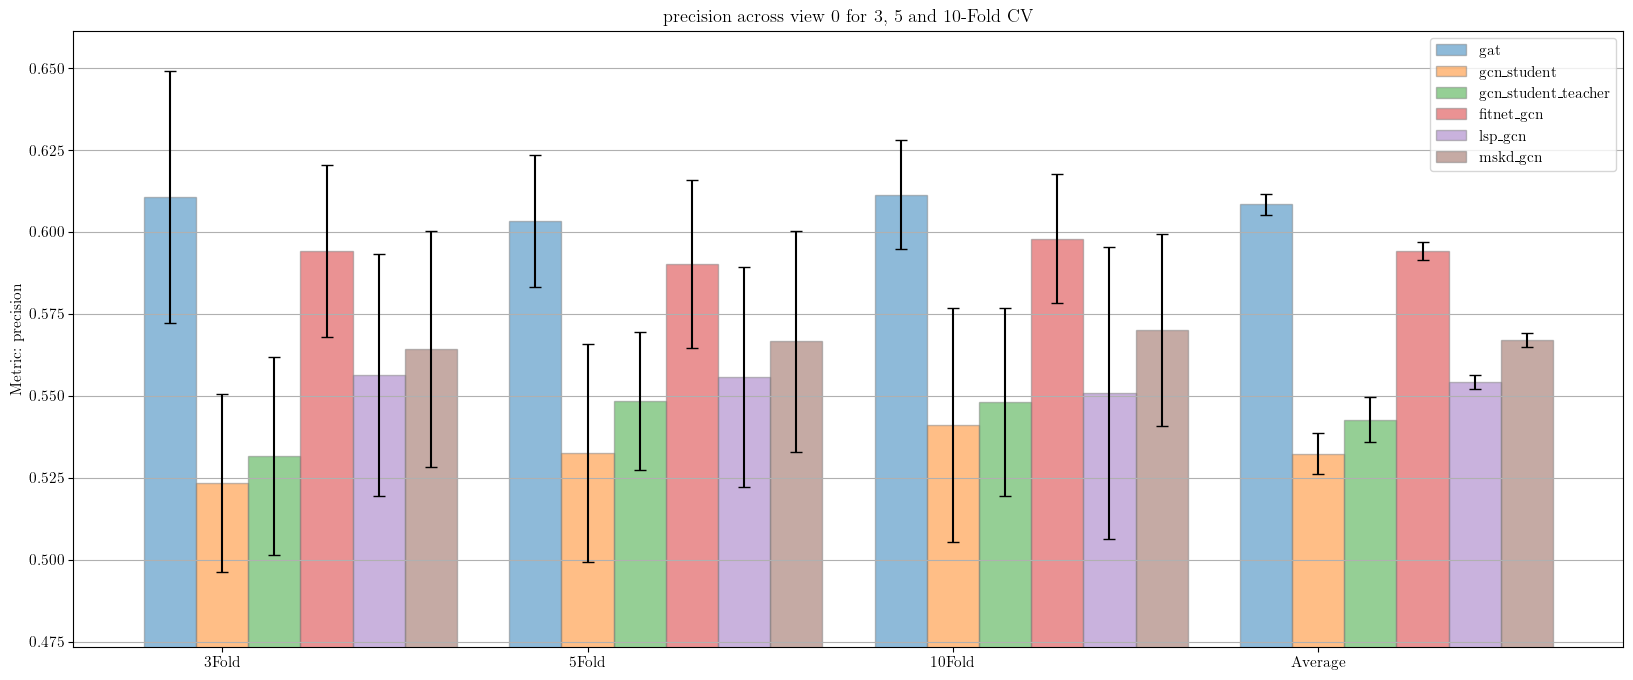

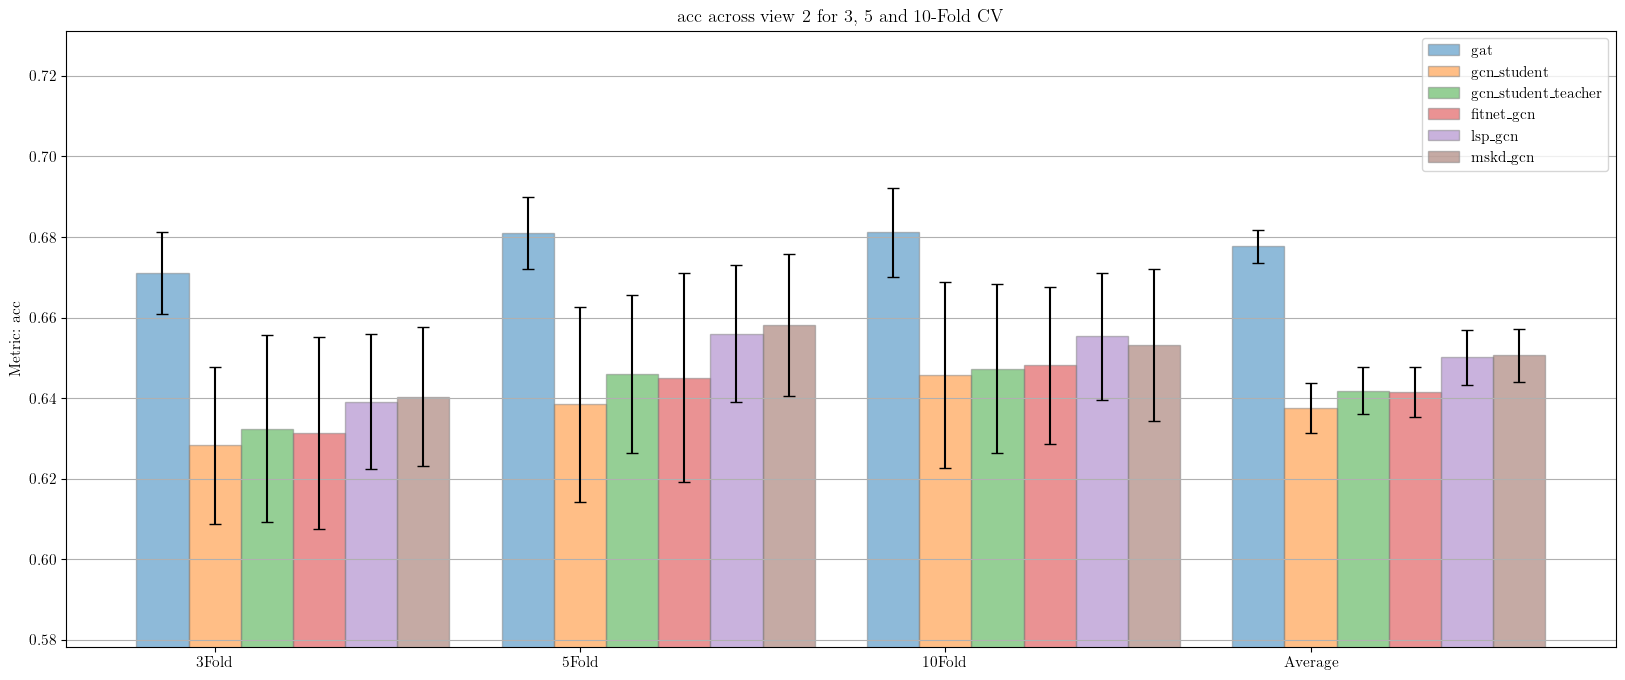

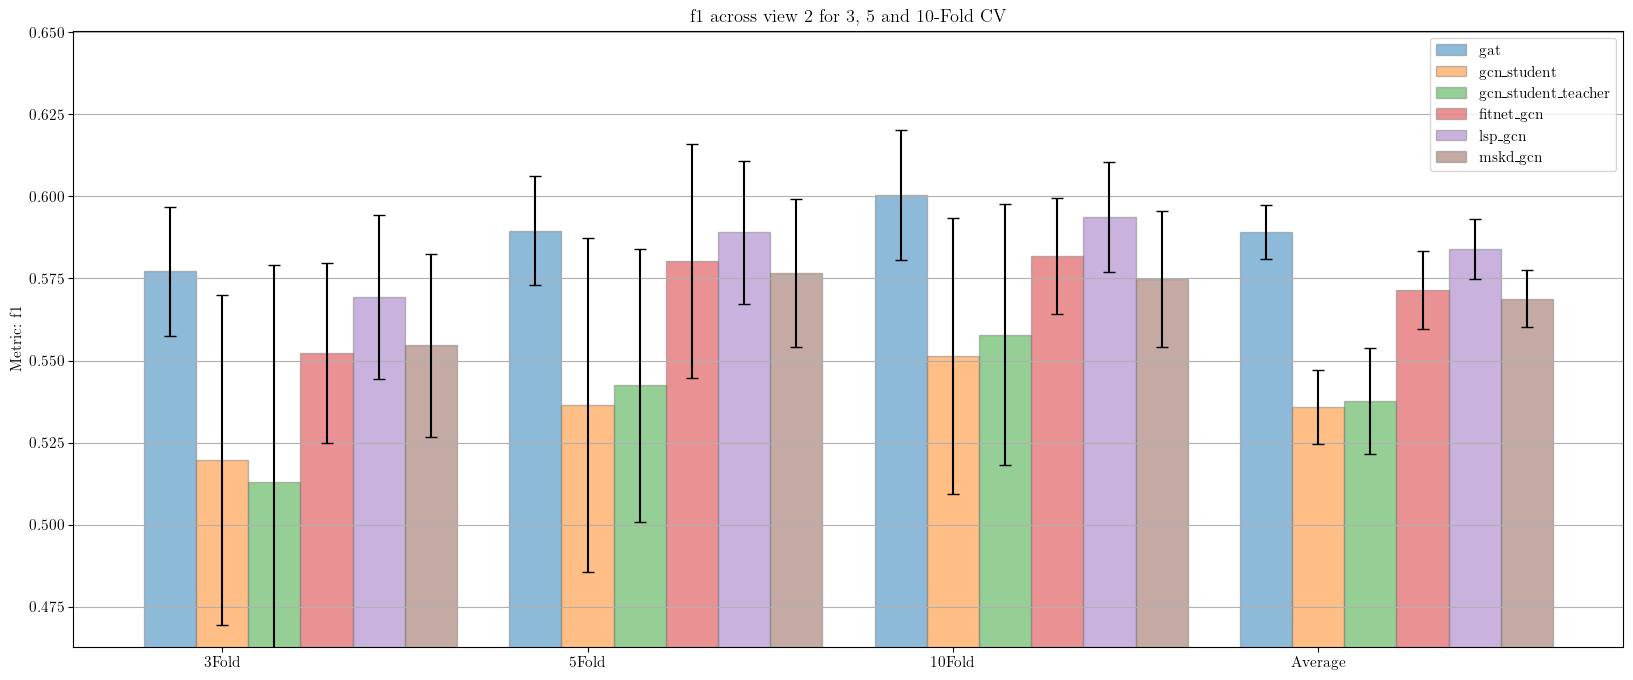

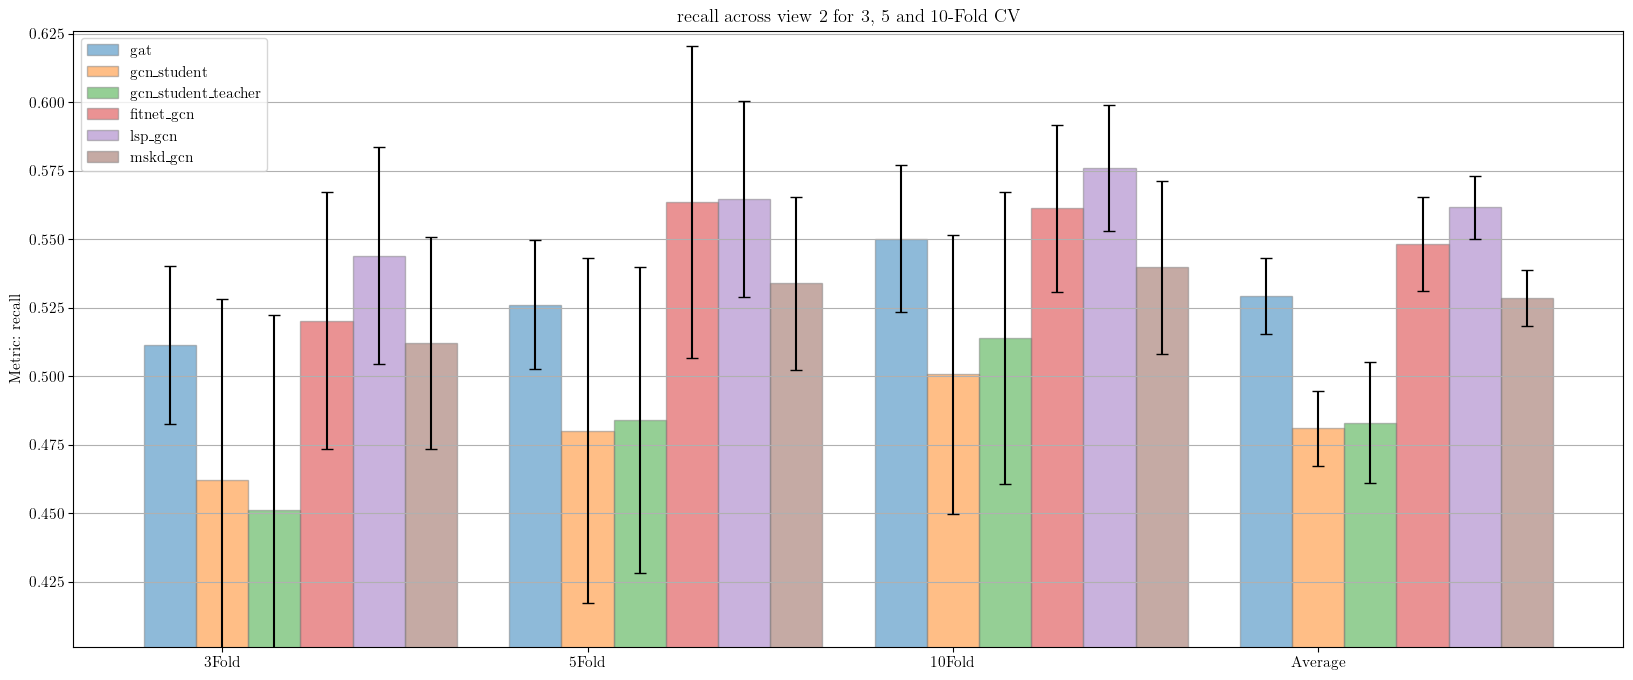

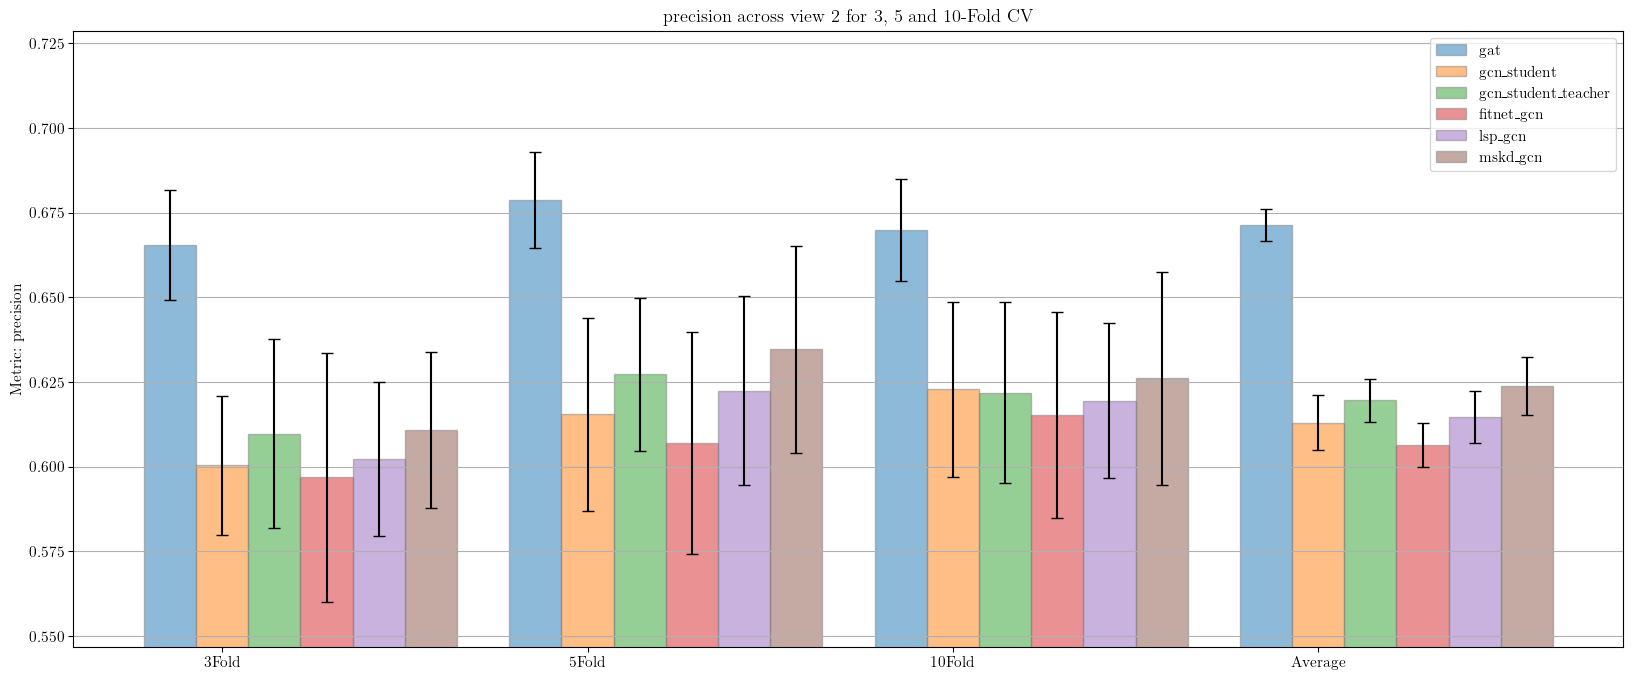

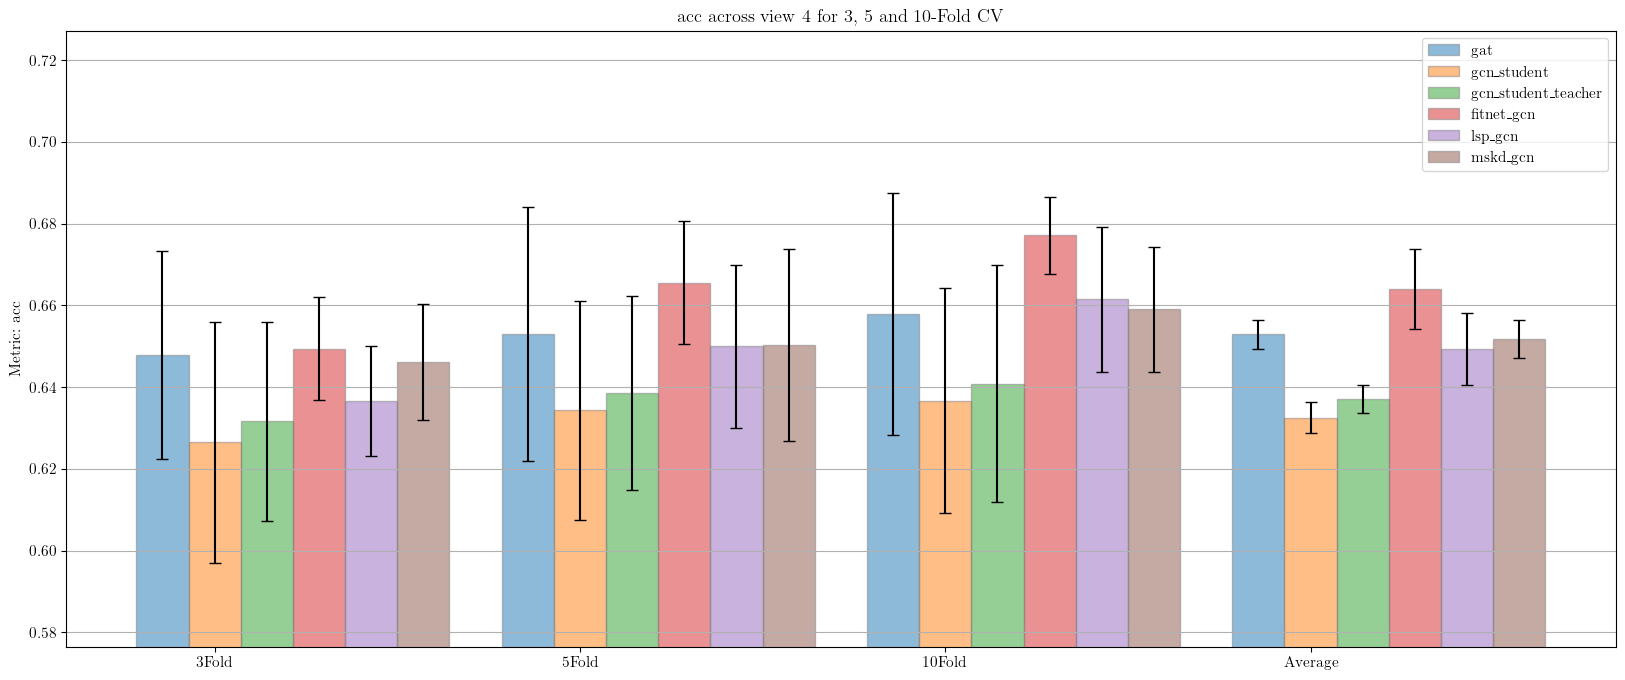

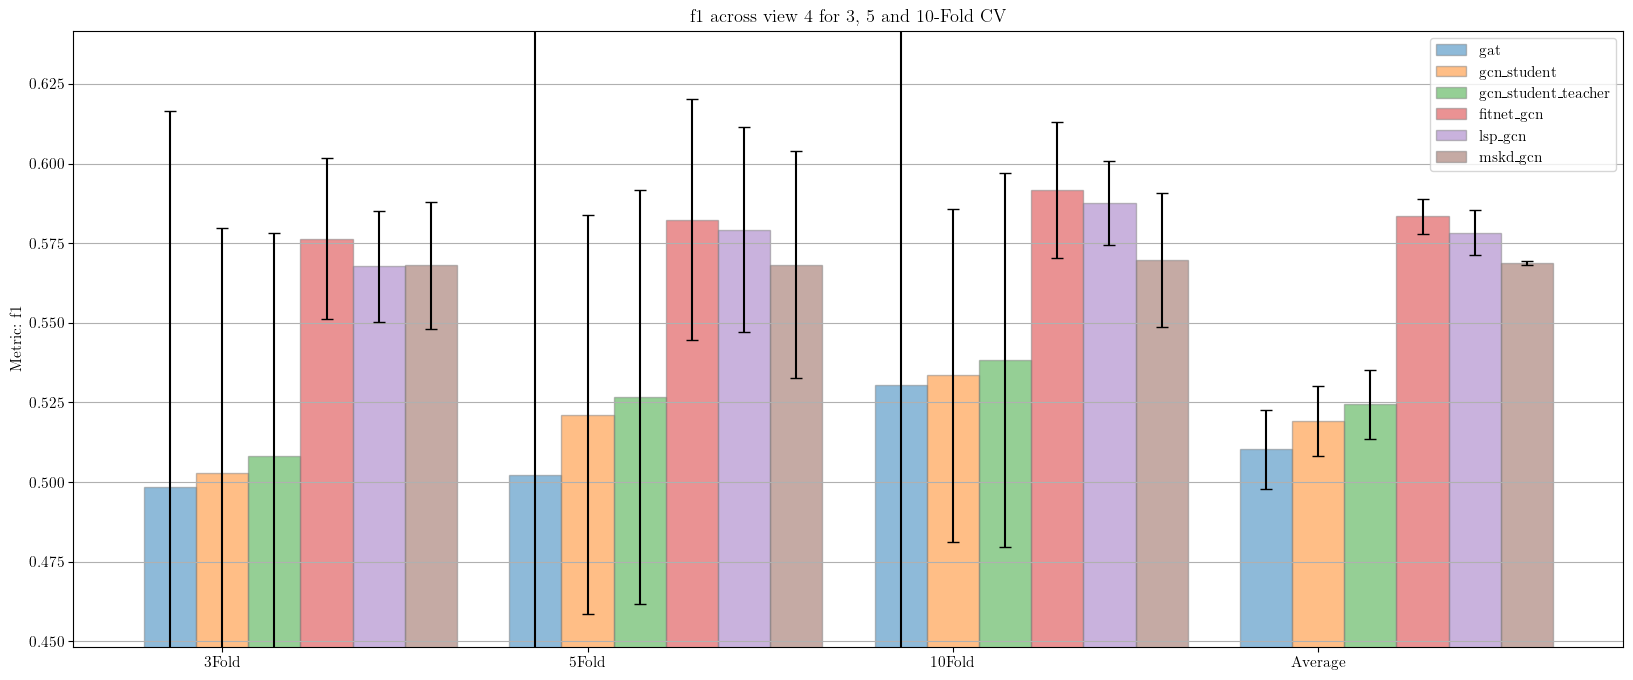

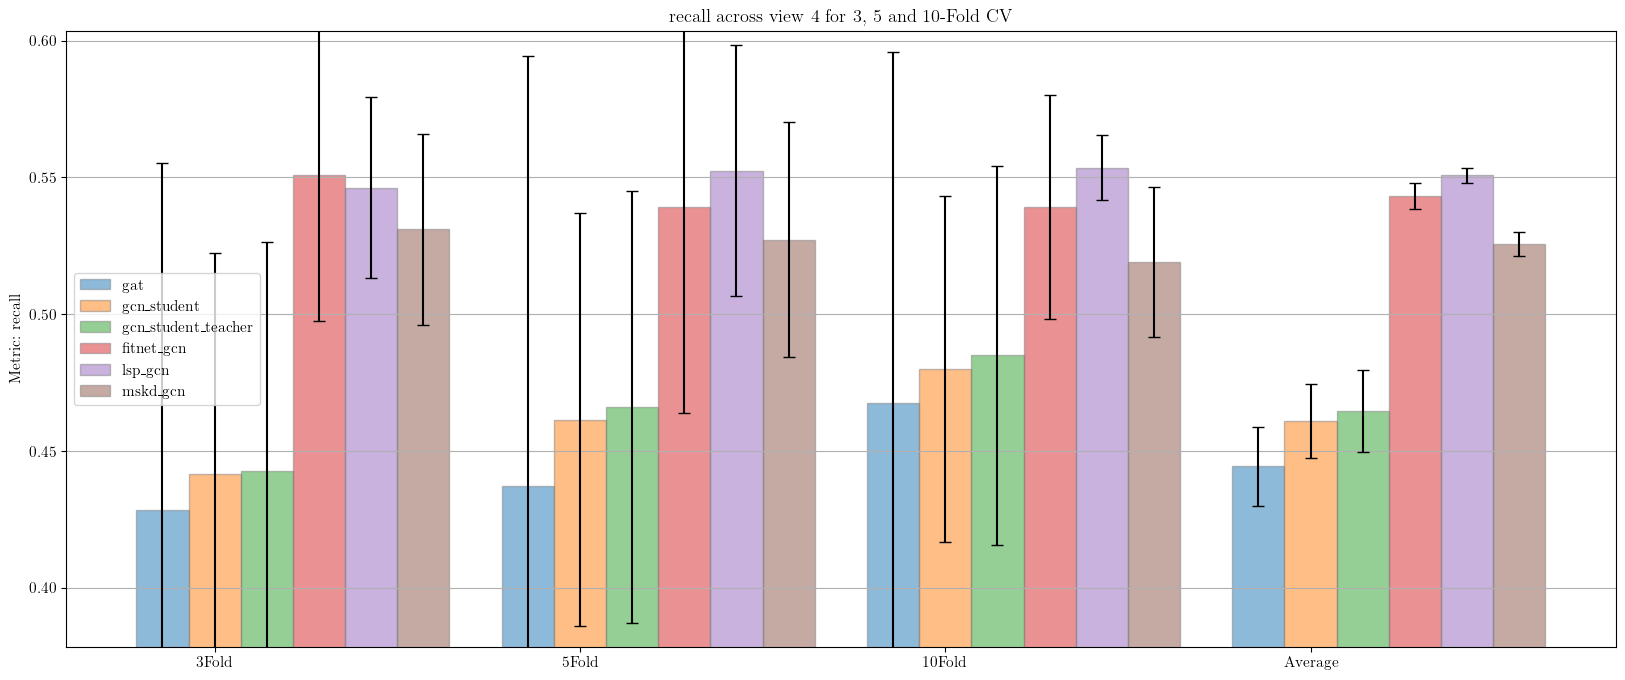

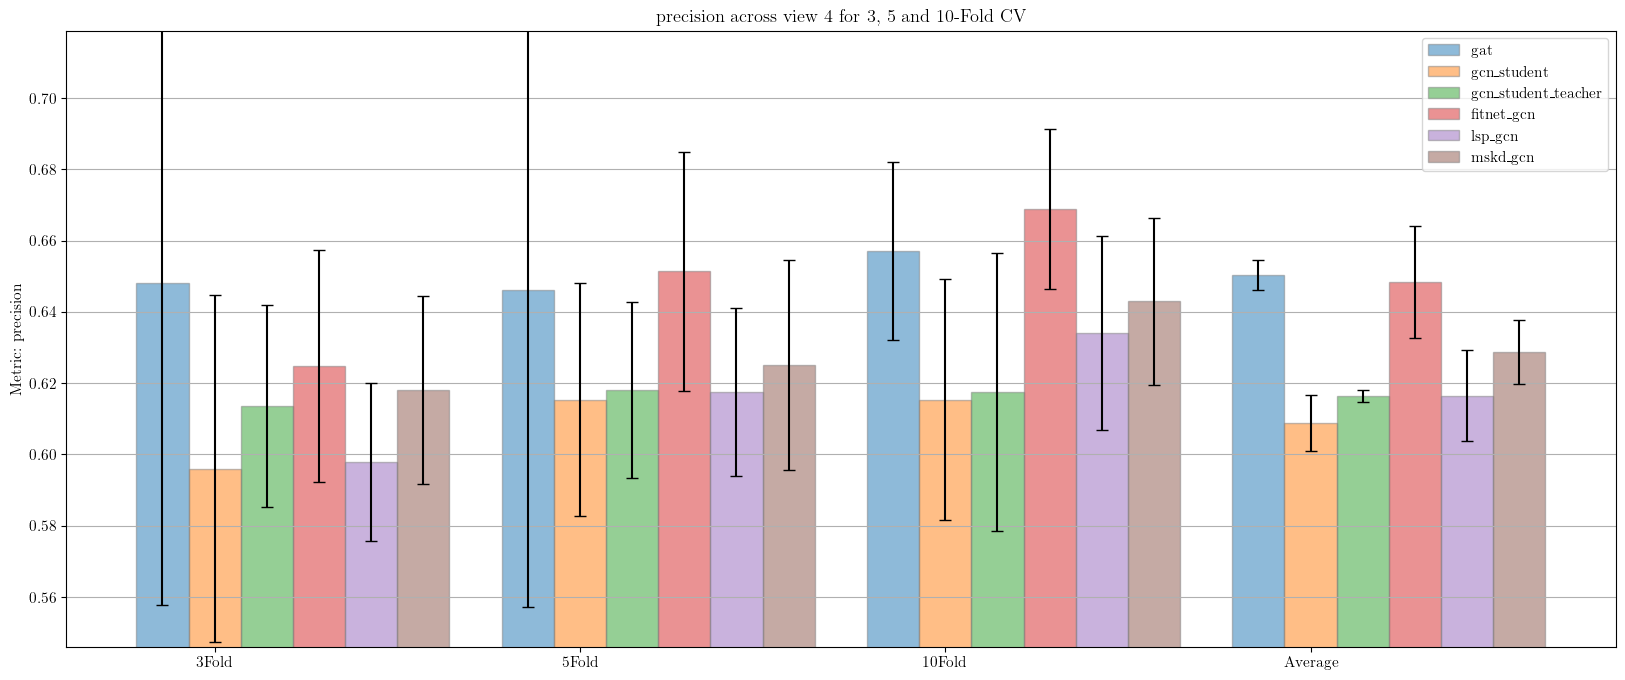

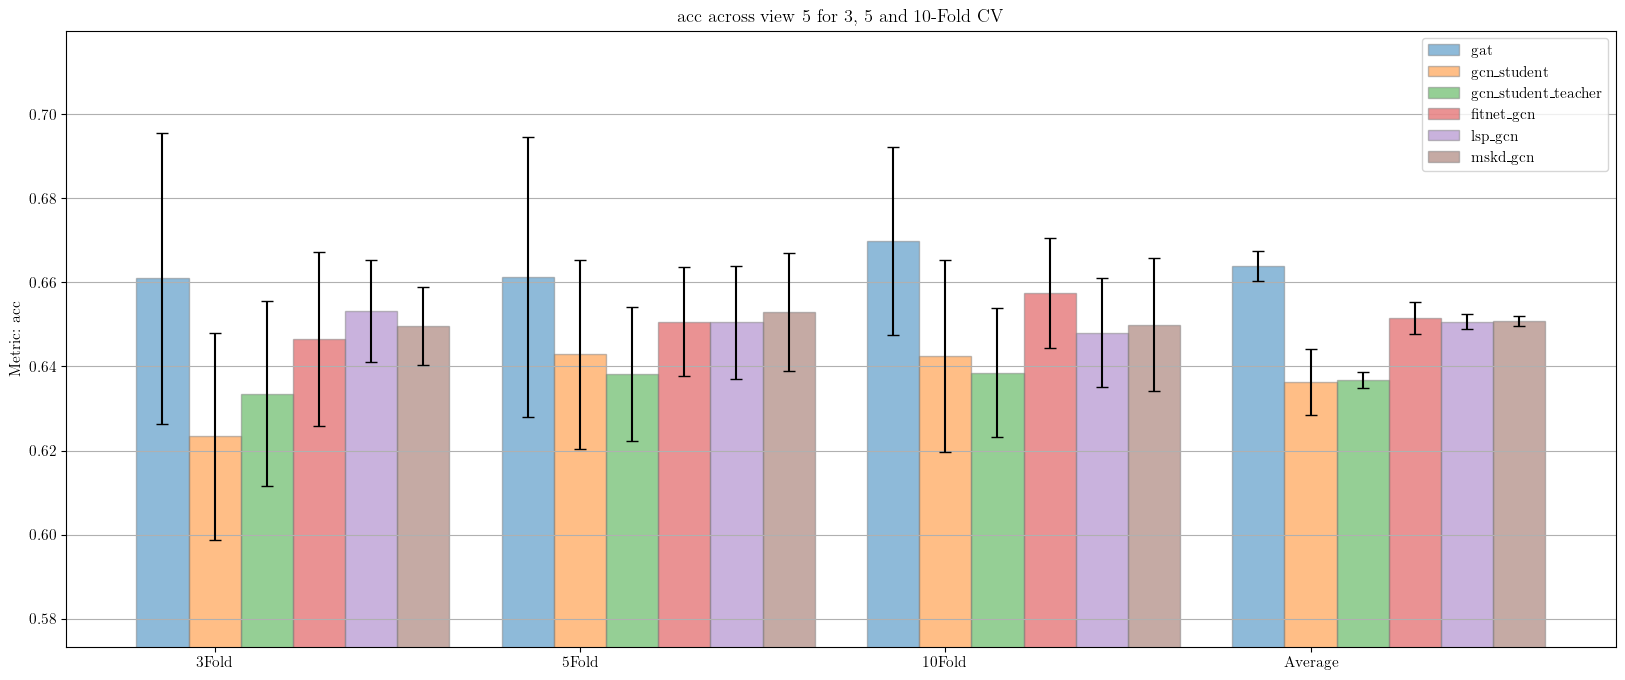

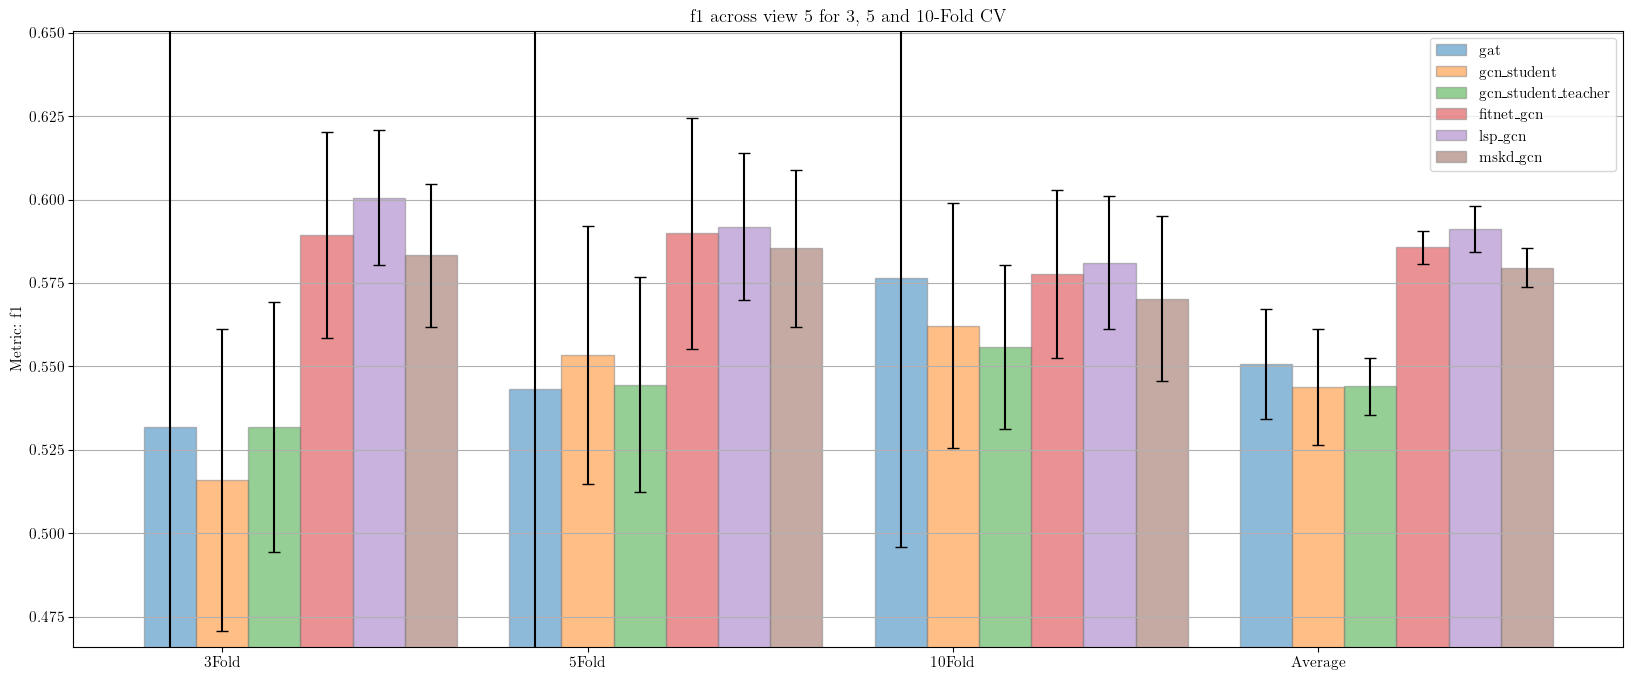

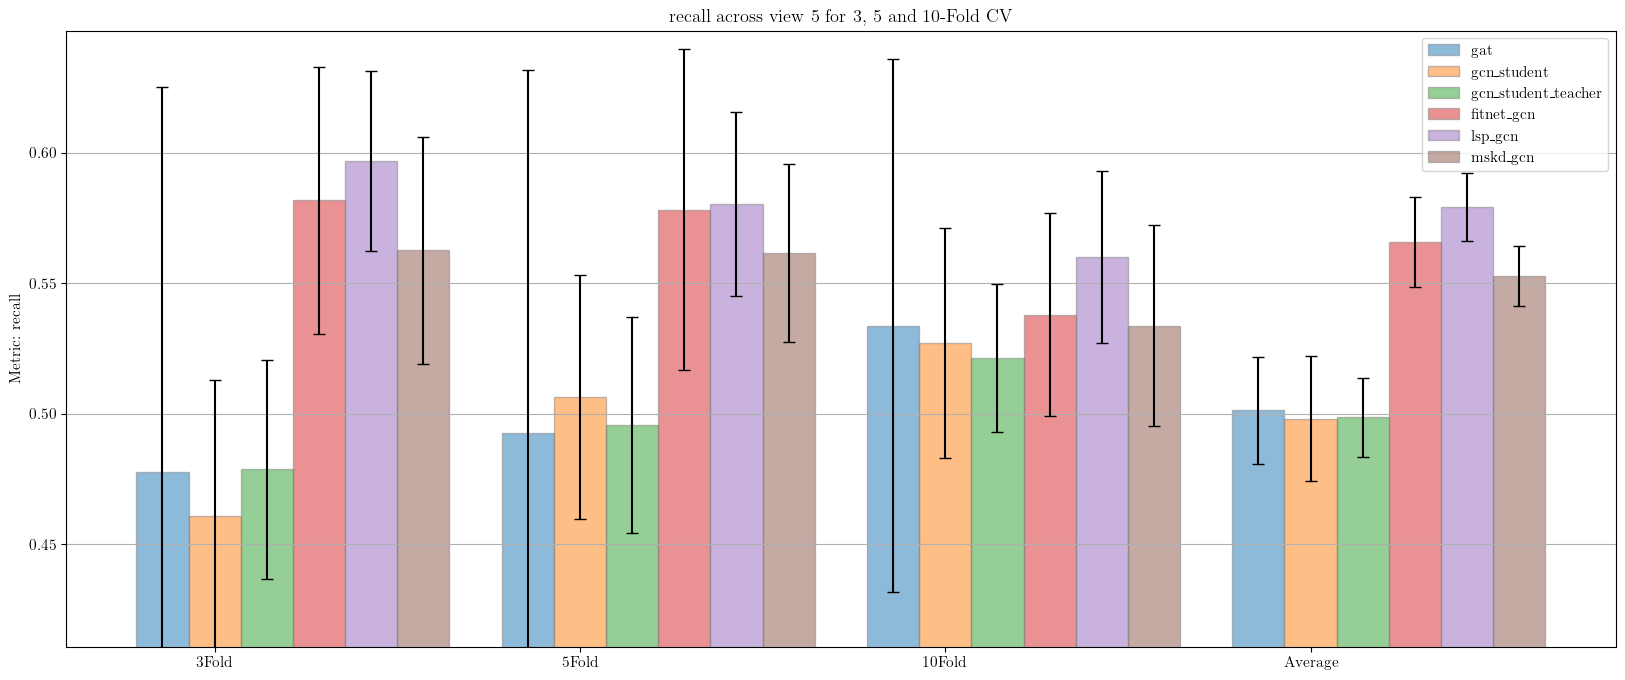

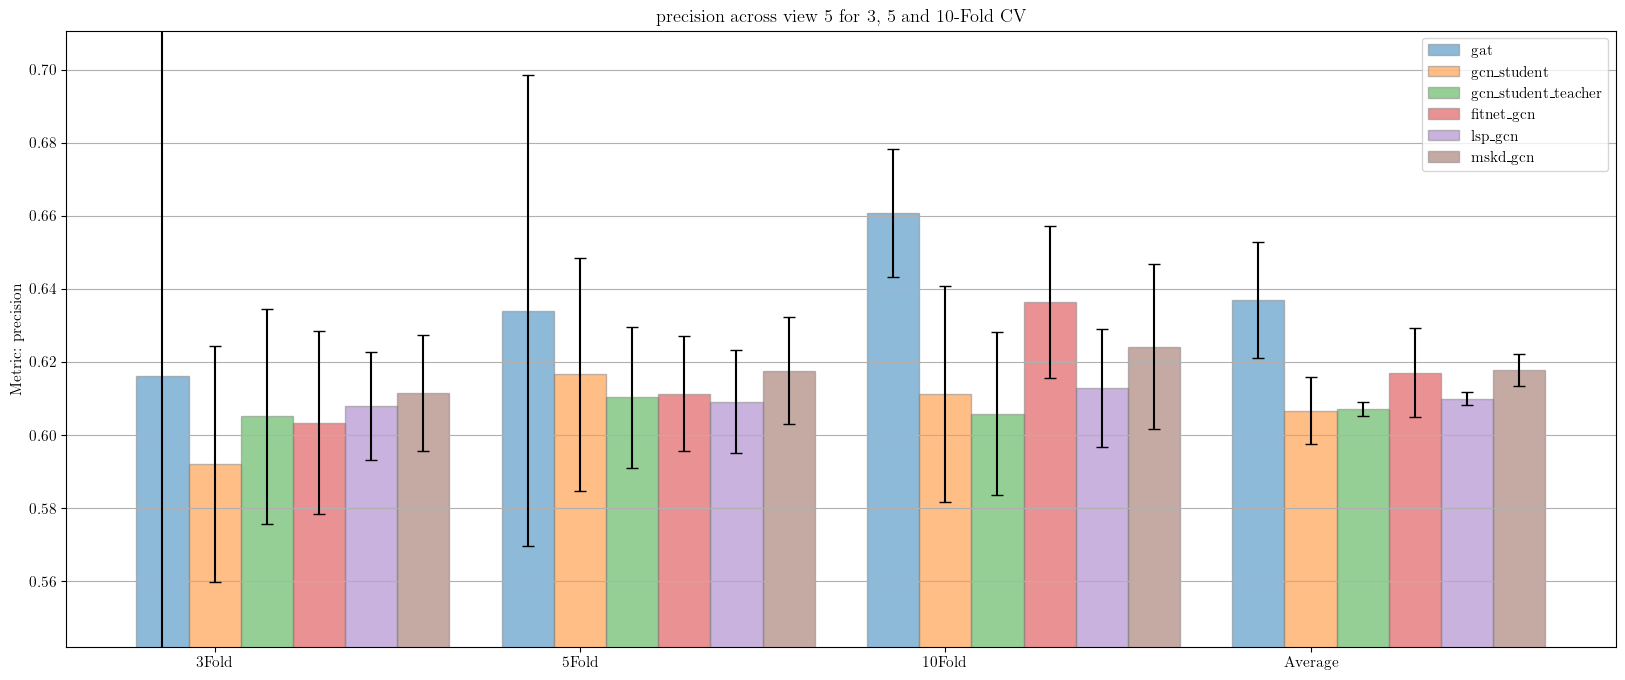

<Figure size 2000x800 with 0 Axes>

In [3]:
for view in [0,2,4,5]:
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="acc", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="f1", model_args=model_args,dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="recall", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="precision", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)

In [4]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [5]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [6]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [7]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []
        ensamble_count = 0

        for j, model in enumerate(models):

            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[ensamble_count][i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)
            
            if "ensamble" in models:
                ensamble_count += 1

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [8]:
def reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None):

    mean_all_runs = []
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    return mean_all_runs, mean_all_std

In [9]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [10]:
analysis_type="model_assessment"
dataset_split="val"
dataset="gender_data"
models_args=[
    gat_student_lsp_ensamble_2_args,
    gat_student_lsp_ensamble_3_args,
    gat_student_lsp_ensamble_4_args,
    gat_student_lsp_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            dataset=dataset,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_2
[[0.9290277777777778, 0.0003196180555555533, 1], [0.9252777777777776, 0.0003648919753086412, 0], [0.9290277777777778, 0.0003196180555555533, 1], [0.9252777777777776, 0.0003648919753086412, 0], [0.9290277777777778, 0.0003196180555555533, 1]]
[[0.9724999999999999, 0.00010254629629629654, 0], [0.8815277777777778, 0.0004008680555555557, 1], [0.8815277777777778, 0.0004008680555555557, 1], [0.9724999999999999, 0.00010254629629629654, 0], [0.9724999999999999, 0.00010254629629629654, 0]]
[[0.94625, 7.67939814814811e-05, 1], [0.94625, 7.67939814814811e-05, 1], [0.94625, 7.67939814814811e-05, 1], [0.94625, 7.67939814814811e-05, 1], [0.94625, 7.67939814814811e-05, 1]]
[[0.946111111111111, 6.666666666666683e-05, 0], [0.9, 0.0004756944444444432, 1], [0.9, 0.0004756944444444432, 1], [0.946111111111111, 6.666666666666683e-05, 0], [0.9, 0.0004756944444444432, 1]]
gcn_student_lsp_ensamble_3
[[0.9730555555555555, 5.7175925925926034e-05, 2], [0.9730555555555555, 5.7175925925926

In [11]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(20, 5)

In [12]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(4):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [13]:
all_data_var = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(4):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [14]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(20, 5)

In [15]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(20, 5)

In [16]:
df_acuracy = df_acuracy.loc['weighted acc'].T
df_var = df_var.loc['weighted acc'].T
df_var = np.sqrt(df_var)

In [17]:
import pandas as pd
# Define the new column labels
new_labels = ['2 w/ LSP', '3 w/ LSP', '4 w/ LSP', '5 w/ LSP']
df_rep = df.loc['weighted acc'].T

# Rename the columns using the new labels
df_rep.columns = new_labels
df_acuracy.columns = new_labels
df_var.columns = new_labels
df_rep, df_acuracy



(   2 w/ LSP  3 w/ LSP  4 w/ LSP  5 w/ LSP
 0  0.925278  0.973056  0.985833  0.965278
 1  0.972500  0.916667  0.953056  0.962222
 2  0.946250  0.961111  0.971111  0.975556
 3  0.946111  0.961944  0.946667  0.988889
 4  0.947535  0.953194  0.964167  0.972986,
    2 w/ LSP  3 w/ LSP  4 w/ LSP  5 w/ LSP
 0  0.553303  0.602258  0.559706  0.578753
 1  0.606885  0.621786  0.613089  0.641658
 2  0.647445  0.643427  0.638887  0.634408
 3  0.607022  0.628068  0.620712  0.568635
 4  0.603664  0.623885  0.608099  0.605863)

In [52]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0,2,4,5], 
    models=["gat", "gcn_student", "gcn_student_teacher", "fitnet_gcn",  "lsp_gcn", "mskd_gcn", "gcn_student_lsp_ensamble_4"],
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [3,1,2,1]
    ], 
    model_args = [
        gat_args, 
        gcn_student_args, 
        gat_student_args, 
        gat_fitnet_student_args, 
        gat_lsp_student_args, 
        gat_mskd_student_args, 
        gat_student_lsp_ensamble_4_args
    ])

In [53]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)

models=["gat", "gcn_student", "gcn_student_teacher", "fitnet_gcn",  "lsp_gcn", "mskd_gcn", "gcn_student_lsp_ensamble_4"]
reproducibility_frame.columns = models

reproducibility_frame["delta teacher"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gat"]) / reproducibility_frame["gat"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100

reproducibility_frame["delta vanilla"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn_student_teacher"]) / reproducibility_frame["gcn_student_teacher"])*100
reproducibility_frame["delta fitnet"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["fitnet_gcn"]) / reproducibility_frame["fitnet_gcn"])*100
reproducibility_frame["delta lsp"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["lsp_gcn"]) / reproducibility_frame["lsp_gcn"])*100
reproducibility_frame["delta mskd"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["mskd_gcn"]) / reproducibility_frame["mskd_gcn"])*100

reproducibility_frame.T*100

,0,1,2,3,4
gat,91.722222,93.333333,91.597222,92.416667,92.267361
gcn_student,92.597222,94.041667,91.166667,93.291667,92.774306
gcn_student_teacher,91.180556,91.875000,93.166667,93.083333,92.326389
fitnet_gcn,76.930556,79.319444,78.236111,79.736111,78.555556
lsp_gcn,73.305556,80.111111,81.972222,83.819444,79.802083
mskd_gcn,71.638889,80.472222,80.333333,82.527778,78.743056
gcn_student_lsp_ensamble_4,98.583333,95.305556,97.111111,94.666667,96.416667
delta teacher,748.031496,211.309524,601.971190,243.462579,449.704587
delta student,646.467677,134.396692,652.041438,147.387226,392.604514
delta vanilla,811.881188,373.393802,423.375075,170.098478,443.023693


In [28]:
pd.DataFrame(mean_all_std.T).T*100


,0,1,2,3,4
0,3.310221,3.361570,5.211295,4.064108,1.307332
1,4.644811,2.196421,3.407848,2.696055,1.628206
2,3.306168,2.191850,3.090582,2.656956,1.618443
3,9.808241,8.564491,9.219764,4.684263,3.485952
4,7.643635,3.655074,7.071286,5.183459,2.739803
5,10.140943,5.629782,8.504311,3.793371,4.108735
6,1.583333,1.531309,0.971825,0.976578,0.574503


In [44]:
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gcn_student_lsp_ensamble_4"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
#model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
model_args= [gat_student_lsp_ensamble_4_args]

best_student = [3,1,2,1]
#best_student_4_lsp = [2,1,2,1]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gat", "gcn_student", "gcn_student_teacher", "fitnet_gcn",  "lsp_gcn", "mskd_gcn"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, model_args= [
                                                                                                                gat_args, 
                                                                                                                gcn_student_args, 
                                                                                                                gat_student_args, 
                                                                                                                gat_fitnet_student_args, 
                                                                                                                gat_lsp_student_args,
                                                                                                                gat_mskd_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

____________________________________________________
View: 0 Metric: acc
____________________________________________________
View: 2 Metric: acc
____________________________________________________
View: 4 Metric: acc
____________________________________________________
View: 5 Metric: acc


In [45]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [46]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df

,0,1,2,3,4,5,6
0,0.620289,0.577844,0.586037,0.629679,0.603985,0.607897,0.559706
1,0.677743,0.637472,0.641877,0.641524,0.650153,0.650605,0.613089
2,0.652876,0.632487,0.637010,0.664002,0.649348,0.651855,0.638887
3,0.663967,0.636227,0.636753,0.651533,0.650582,0.650806,0.620712
4,0.653719,0.621007,0.625419,0.646685,0.638517,0.640290,0.608099


In [47]:
average_across_views_df = pd.DataFrame(average_across_views_df)
models=["gat", "gcn_student", "gcn_student_teacher", "fitnet_gcn",  "lsp_gcn", "mskd_gcn", "gcn_student_lsp_ensamble_4"]

average_across_views_df.columns = models

average_across_views_df["delta teacher"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gat"]) / average_across_views_df["gat"])*100
average_across_views_df["delta student"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn_student"]) / average_across_views_df["gcn_student"])*100

average_across_views_df["delta vanilla"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn_student_teacher"]) / average_across_views_df["gcn_student_teacher"])*100
average_across_views_df["delta fitnet"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["fitnet_gcn"]) / average_across_views_df["fitnet_gcn"])*100
average_across_views_df["delta lsp"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["lsp_gcn"]) / average_across_views_df["lsp_gcn"])*100
average_across_views_df["delta mskd"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["mskd_gcn"]) / average_across_views_df["mskd_gcn"])*100

In [48]:
average_across_views_df.T*100

,0,1,2,3,4
gat,62.028917,67.774275,65.287638,66.396705,65.371884
gcn_student,57.784444,63.747176,63.248662,63.622665,62.100737
gcn_student_teacher,58.603718,64.187689,63.701023,63.675328,62.541940
fitnet_gcn,62.967910,64.152418,66.400213,65.153264,64.668451
lsp_gcn,60.398509,65.015335,64.934809,65.058197,63.851713
mskd_gcn,60.789651,65.060484,65.185481,65.080568,64.029046
gcn_student_lsp_ensamble_4,55.970602,61.308913,63.888748,62.071197,60.809865
delta teacher,-976.692047,-953.955191,-214.265705,-651.464313,-697.856427
delta student,-313.898045,-382.489538,101.201475,-243.854590,-207.867392
delta vanilla,-449.308691,-448.493511,29.469745,-251.923527,-276.946089


In [54]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_std[i][:,-1])
average_across_views_df = pd.DataFrame(average_across_views)
average_across_views_df.T*100

,0,1,2,3
0,0.312894,0.089857,0.234458,0.552232
1,0.279307,0.198404,0.111084,0.086607
2,0.309942,0.149138,0.243581,0.299199
3,0.117339,0.270396,0.229120,0.363787
4,0.313266,0.057501,0.269192,0.053290
5,0.243342,0.067812,0.413573,0.280128
6,0.188370,0.031480,0.011657,0.242034


In [57]:
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gcn_student_lsp_ensamble_4"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["f1"]
#model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
model_args= [gat_student_lsp_ensamble_4_args]

best_student = [3,1,2,1]
#best_student_4_lsp = [2,1,2,1]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gat", "gcn_student", "gcn_student_teacher", "fitnet_gcn",  "lsp_gcn", "mskd_gcn"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, model_args= [
                                                                                                                gat_args, 
                                                                                                                gcn_student_args, 
                                                                                                                gat_student_args, 
                                                                                                                gat_fitnet_student_args, 
                                                                                                                gat_lsp_student_args,
                                                                                                                gat_mskd_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,1]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,1]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

____________________________________________________
View: 0 Metric: f1
____________________________________________________
View: 2 Metric: f1
____________________________________________________
View: 4 Metric: f1
____________________________________________________
View: 5 Metric: f1


In [58]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [59]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df

,0,1,2,3,4,5,6
0,0.620289,0.577844,0.586037,0.629679,0.603985,0.607897,0.207784
1,0.677743,0.637472,0.641877,0.641524,0.650153,0.650605,0.541547
2,0.652876,0.632487,0.637010,0.664002,0.649348,0.651855,0.570538
3,0.663967,0.636227,0.636753,0.651533,0.650582,0.650806,0.546472
4,0.653719,0.621007,0.625419,0.646685,0.638517,0.640290,0.466585
